In [1]:
import numpy as np
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
import os
import json
import datetime

plt.rcParams["figure.figsize"] = (20, 5)

In [3]:
data = pd.read_csv("../로그 데이터/GEMM_21gb_gpa_pf_stride.csv")
data

,Unnamed: 0,Unnamed: 0.1,Category,gpa_counter,gpa,rip,vmid,gpanext,gpa_stride,ripnext,rip_stride
0,0,0,1,1262183,14549076593,-1617868175,2921,14549076926,-333,-1617867842,-333
1,1,1,1,1262184,14549076926,-1617867842,2921,24603935088,-10054858162,-1617867842,0
2,2,2,1,1262185,24603935088,-1617867842,2921,14549076926,10054858162,-1617867842,0
3,3,3,1,1262186,14549076926,-1617867842,2921,24603935092,-10054858166,-1617867842,0
4,4,4,1,1262187,24603935092,-1617867842,2921,14549076926,10054858166,-1617867842,0
...,...,...,...,...,...,...,...,...,...,...,...
8233,8233,8233,1,1269182,14549076926,-1617867842,2921,24603935096,-10054858170,-1617867842,0
8234,8234,8234,1,1269183,24603935096,-1617867842,2921,14549076926,10054858170,-1617867842,0
8235,8235,8235,1,1269184,14549076926,-1617867842,2921,14549076593,333,-1617868175,333
8236,8236,8236,1,1269185,14549076593,-1617868175,2921,18645336064,-4096259471,-1617868175,0


In [4]:
delta = np.array([data[i+1] - data[i] for i in range(int(len(data))-1)])
delta, len(delta)

(array([-4293926805,      -28563,       36408, ...,    -7958528,
            1081344,    -7450624], dtype=int64),
 53426)

In [5]:
data_counts = pd.Series(data=delta.T).value_counts()
data_counts

 4096           44968
 12288           3009
 2097152         1489
-6291456          626
 36864            458
                ...  
 4260769812         1
 59730530368        1
 6197376            1
-3219958009         1
-20807680           1
Length: 622, dtype: int64

In [6]:
def category_by_threshold(data_counts, threshold, sign="over"):
    if sign == "under":
        category = (data_counts < threshold)
    else:
        category = (data_counts > threshold)
    return category.index[category == True]

In [7]:
def tokenizer(data, category, oov=-1):
    data = data.copy()
    mask = np.isin(data, category)
    data[mask == False] = oov
    return data

In [8]:
threshold = 100
category_over_threshold = category_by_threshold(data_counts, threshold)
category_over_threshold

Int64Index([4096, 12288, 2097152, -6291456, 36864, 98304, 61440, 0, 24576], dtype='int64')

In [9]:
tokenized_data = tokenizer(delta, category_over_threshold.to_numpy(), oov=-1)
tokenized_data

array([-1, -1, -1, ..., -1, -1, -1], dtype=int64)

In [10]:
tokenized_data_counts = pd.Series(data=tokenized_data.T).value_counts()
tokenized_data_counts

 4096       44968
 12288       3009
-1           1557
 2097152     1489
-6291456      626
 36864        458
 98304        427
 61440        372
 0            362
 24576        158
dtype: int64

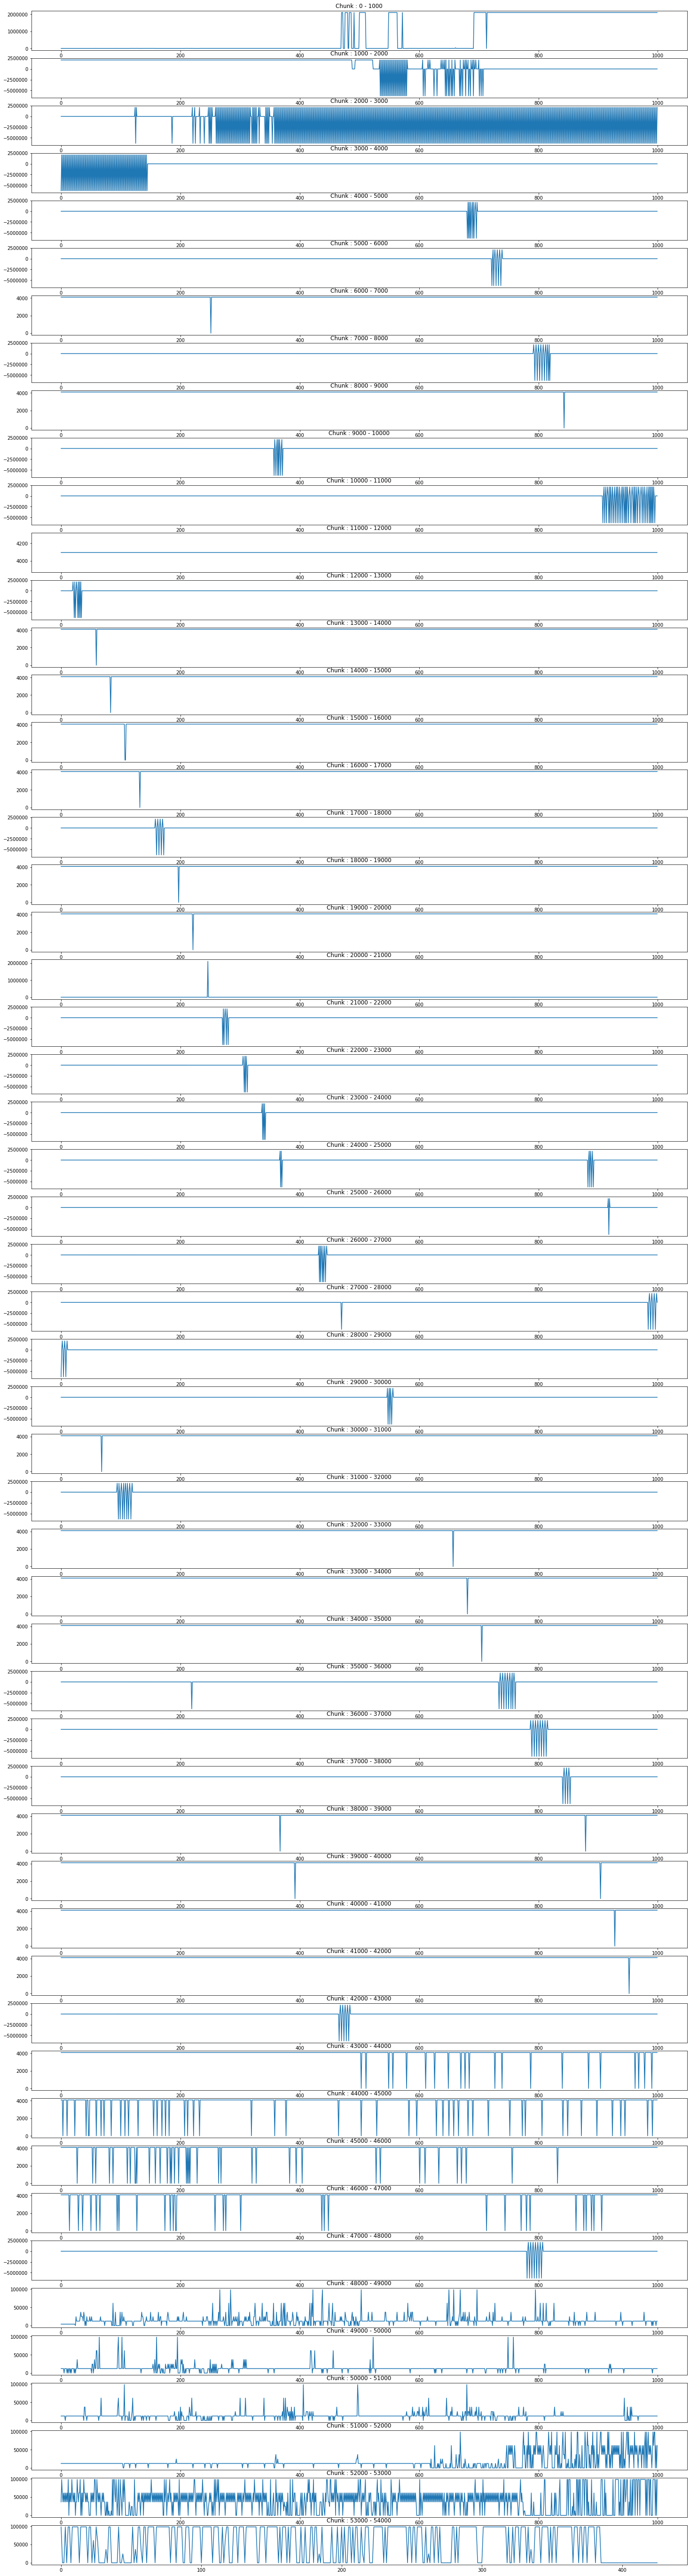

In [11]:
plt.figure(figsize=(25, 100))
num_chunk = len(delta)//1000 + 1
for i in range(num_chunk):
        ax = plt.subplot(num_chunk, 1, i+1)
        title = plt.title("Chunk : {} - {}".format(i*1000, (i+1)*1000))
        plot = plt.plot(tokenized_data[i*1000:(i+1)*1000])

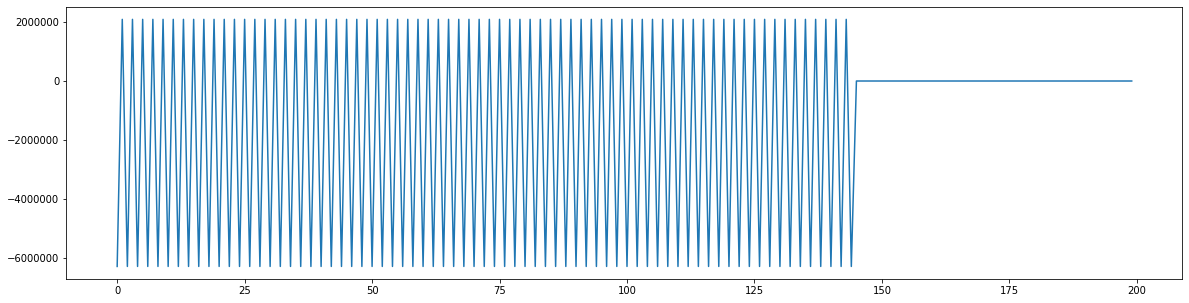

In [12]:
plt.plot(tokenized_data[3000:3200])

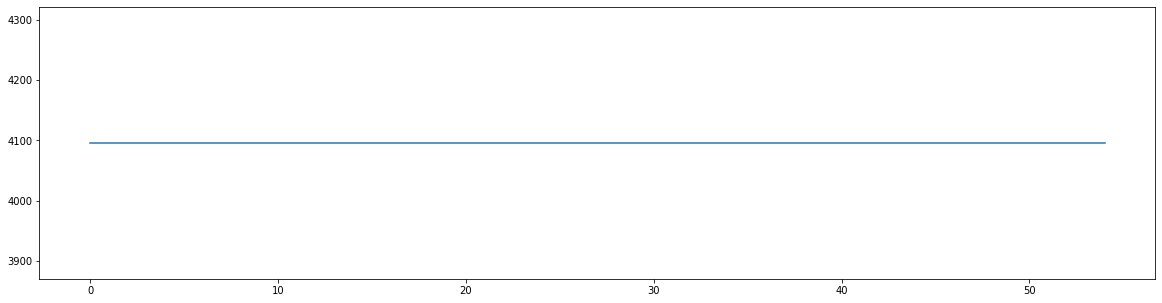

In [13]:
plt.plot(tokenized_data[3145:3200])

In [14]:
initial_stage_index = 3145

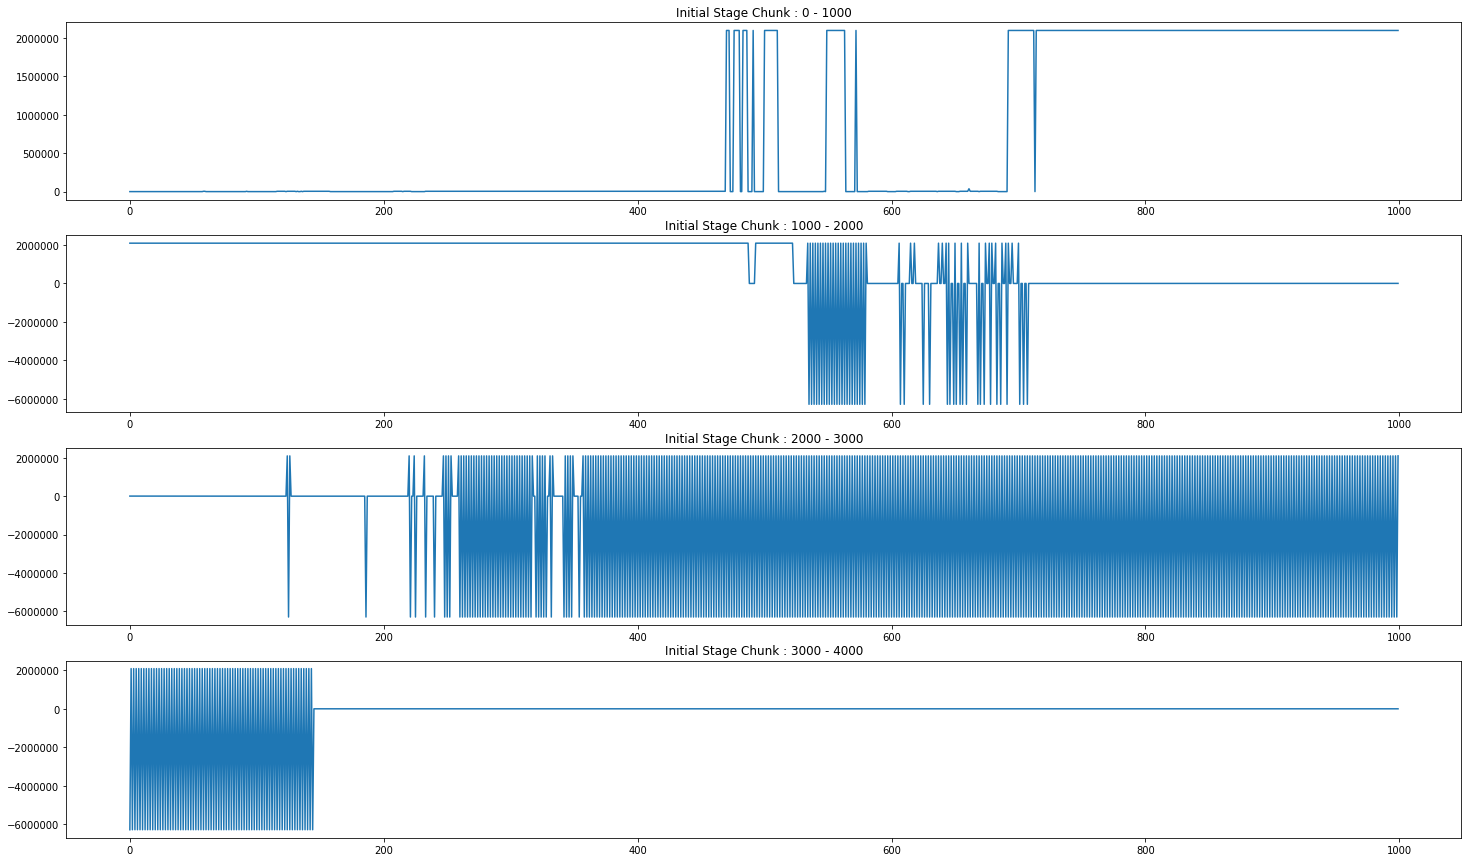

In [15]:
plt.figure(figsize=(25, 15))
num_chunk = initial_stage_index//1000 + 1
for i in range(num_chunk):
        ax = plt.subplot(num_chunk, 1, i+1)
        title = plt.title("Initial Stage Chunk : {} - {}".format(i*1000, (i+1)*1000))
        plot = plt.plot(tokenized_data[i*1000:(i+1)*1000])

In [16]:
tokenized_data[initial_stage_index:3200]

array([4096, 4096, 4096, 4096, 4096, 4096, 4096, 4096, 4096, 4096, 4096,
       4096, 4096, 4096, 4096, 4096, 4096, 4096, 4096, 4096, 4096, 4096,
       4096, 4096, 4096, 4096, 4096, 4096, 4096, 4096, 4096, 4096, 4096,
       4096, 4096, 4096, 4096, 4096, 4096, 4096, 4096, 4096, 4096, 4096,
       4096, 4096, 4096, 4096, 4096, 4096, 4096, 4096, 4096, 4096, 4096],
      dtype=int64)

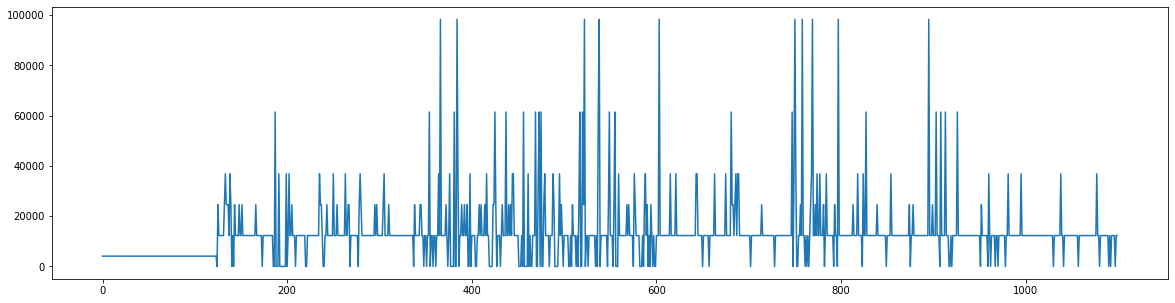

In [17]:
plt.plot(tokenized_data[47900:49000])

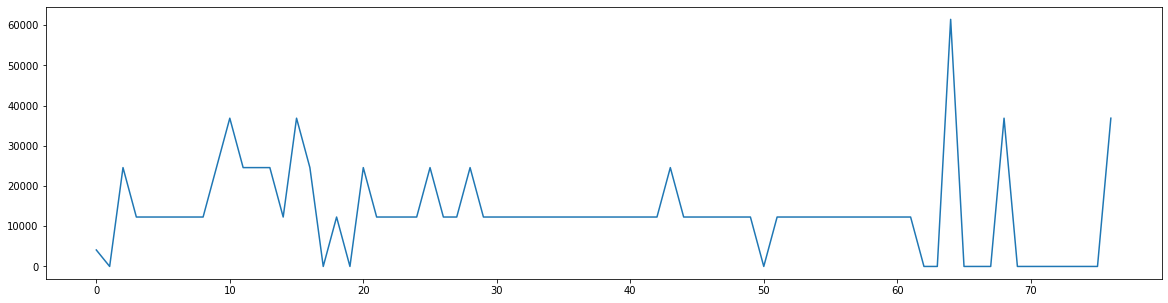

In [18]:
plt.plot(tokenized_data[48023:48100])

In [29]:
terminal_stage_index = 48023

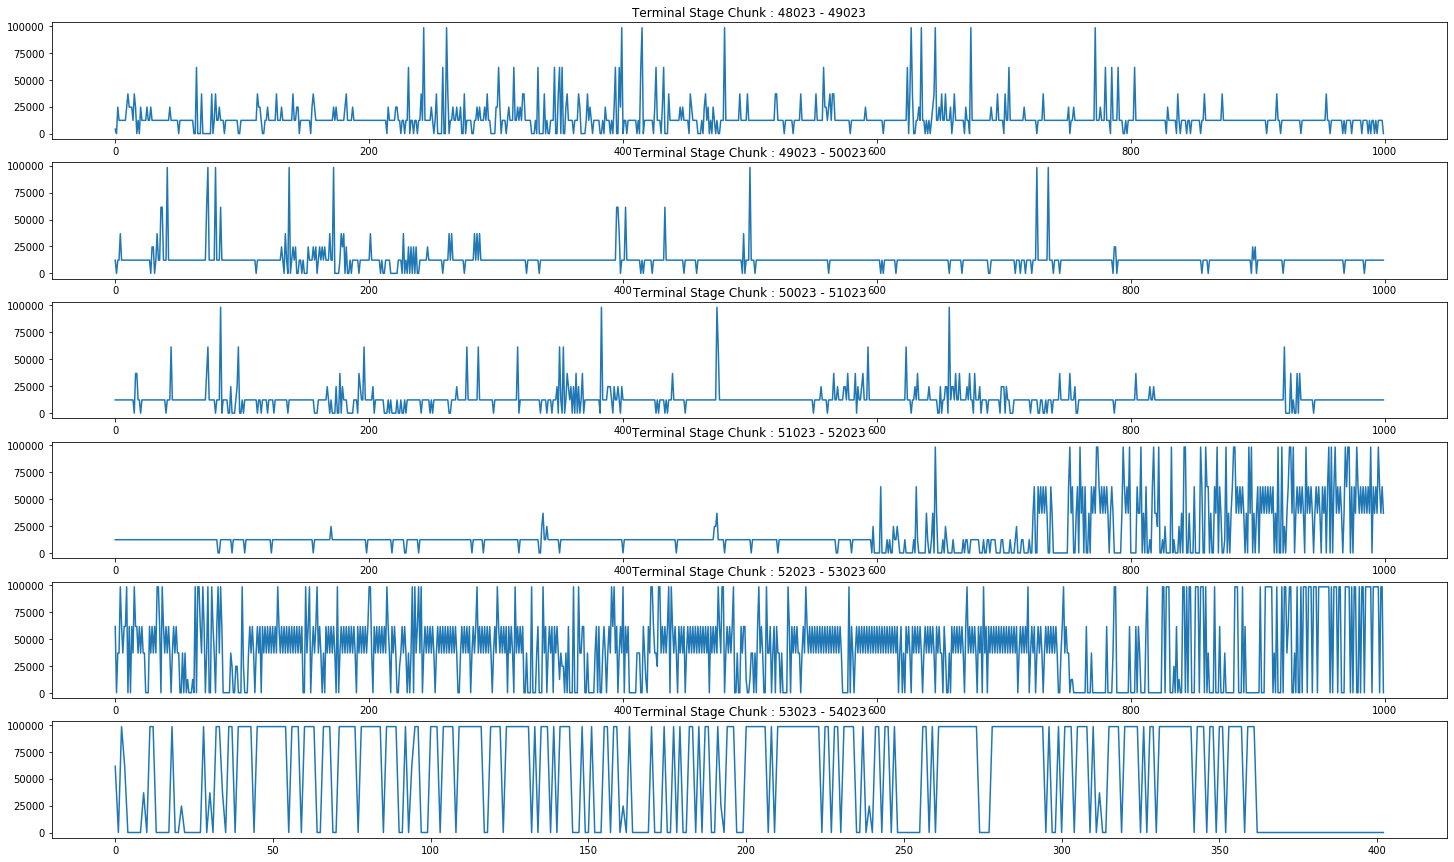

In [20]:
plt.figure(figsize=(25, 15))
num_chunk = (len(delta) - terminal_stage_index)//1000 + 1
for i in range(num_chunk):
        ax = plt.subplot(num_chunk, 1, i+1)
        title = plt.title("Terminal Stage Chunk : {} - {}".format(terminal_stage_index + i*1000, terminal_stage_index + (i+1)*1000))
        plot = plt.plot(tokenized_data[terminal_stage_index + i*1000:terminal_stage_index + (i+1)*1000])

In [30]:
processed_dataset = pd.DataFrame(data=np.c_[data[initial_stage_index:terminal_stage_index], data[initial_stage_index+1:terminal_stage_index+1], delta[initial_stage_index:terminal_stage_index], tokenized_data[initial_stage_index:terminal_stage_index]], columns=["t", "t+1", "delta", "tokenized_data"])
processed_dataset

,t,t+1,delta,tokenized_data
0,104291368960,104291373056,4096,4096
1,104291373056,104291377152,4096,4096
2,104291377152,104291381248,4096,4096
3,104291381248,104291385344,4096,4096
4,104291385344,104291389440,4096,4096
...,...,...,...,...
44873,103535153152,103535157248,4096,4096
44874,103535157248,103535161344,4096,4096
44875,103535161344,103535165440,4096,4096
44876,103535165440,103535169536,4096,4096


In [31]:
for i in range(18000, 19000):
    print(processed_dataset["t+1"][i] - processed_dataset["t"][i], processed_dataset["delta"][i])

4096 4096
4096 4096
4096 4096
4096 4096
4096 4096
4096 4096
4096 4096
4096 4096
4096 4096
4096 4096
4096 4096
4096 4096
4096 4096
4096 4096
4096 4096
4096 4096
4096 4096
4096 4096
4096 4096
4096 4096
4096 4096
4096 4096
4096 4096
4096 4096
4096 4096
4096 4096
4096 4096
4096 4096
4096 4096
4096 4096
4096 4096
4096 4096
4096 4096
4096 4096
4096 4096
4096 4096
4096 4096
4096 4096
4096 4096
4096 4096
4096 4096
4096 4096
4096 4096
4096 4096
4096 4096
4096 4096
4096 4096
4096 4096
4096 4096
4096 4096
4096 4096
4096 4096
4096 4096
4096 4096
4096 4096
4096 4096
4096 4096
4096 4096
4096 4096
4096 4096
4096 4096
4096 4096
4096 4096
4096 4096
4096 4096
4096 4096
4096 4096
4096 4096
4096 4096
4096 4096
4096 4096
4096 4096
4096 4096
4096 4096
4096 4096
4096 4096
4096 4096
4096 4096
4096 4096
4096 4096
4096 4096
4096 4096
4096 4096
4096 4096
4096 4096
4096 4096
4096 4096
4096 4096
4096 4096
4096 4096
4096 4096
4096 4096
4096 4096
4096 4096
4096 4096
4096 4096
4096 4096
4096 4096
4096 4096
4096 4096


In [32]:
processed_dataset["tokenized_data"].value_counts()

 4096       44205
 0            354
-6291456      139
 2097152      137
-1             43
Name: tokenized_data, dtype: int64

In [33]:
from sklearn.model_selection import train_test_split

train_set, test_set = train_test_split(processed_dataset, test_size=0.25, shuffle=False)
train_set, test_set

(                  t           t+1    delta  tokenized_data
 0      104291368960  104291373056     4096            4096
 1      104291373056  104291377152     4096            4096
 2      104291377152  104291381248     4096            4096
 3      104291381248  104291385344     4096            4096
 4      104291385344  104291389440     4096            4096
 ...             ...           ...      ...             ...
 33653  103658029056  103658029056        0               0
 33654  103658029056  103660126208  2097152         2097152
 33655  103660126208  103660126208        0               0
 33656  103660126208  103653834752 -6291456        -6291456
 33657  103653834752  103653834752        0               0
 
 [33658 rows x 4 columns],
                   t           t+1    delta  tokenized_data
 33658  103653834752  103655931904  2097152         2097152
 33659  103655931904  103655931904        0               0
 33660  103655931904  103649640448 -6291456        -6291456
 33661  103

train_set.to_csv("data/StreamBench_1G1P_train_set.csv", index=False)
test_set.to_csv("data/StreamBench_1G1P_test_set.csv", index=False)